<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> # Earth Satellites
>
> Skyfield is able to predict the positions of Earth satellites by loading satellite orbital elements from Two-Line Element (TLE) files — published by organizations like CelesTrak — and running them through the SGP4 satellite propagation routine. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skyfield.api import load, wgs84

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE file
>
> Skyfield loader objects offer a tle_file() method that can download and cache a file full of satellite elements from a site like Celestrak. A popular observing target for satellite observers is the International Space Station, which is listed in Celestrak’s stations.txt file:

In [2]:
# stations_url = 'https://www.celestrak.com/NORAD/elements/geo.txt'
stations_url = 'https://celestrak.com/NORAD/elements/weather.txt'


satellites = load.tle_file(stations_url, reload=False)

by_name = {sat.name: sat for sat in satellites}
satellite = by_name['METOP-B'] # how to choose the satellite? => MetOp A/B/C or COMS => We arbitrarly choose METOP-B.

print(satellite)

METOP-B catalog #38771 epoch 2021-11-25 10:36:54 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE set from strings
> If your program already has the two lines of TLE data for a satellite and doesn’t need Skyfield to download and parse a Celestrak file, you can instantiate an EarthSatellite directly.

In [3]:
from skyfield.api import EarthSatellite

ts = load.timescale()
line1 = '1 38771U 12049A   21328.15653177  .00000019  00000+0  28851-4 0  9990'
line2 = '2 38771  98.6954  26.0543 0000110 196.3188 189.2859 14.21494351476561'

satellite = EarthSatellite(line1, line2, 'METOP-B', ts)

print(ts)
print(satellite)

METOP-B catalog #38771 epoch 2021-11-24 03:45:24 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Satellite altitude, azimuth, and distance
>
> You might be most interested in whether the satellite is above or below the horizon from your own position as an observer, and in which direction to look for it. If you build an object to represent your latitude and longitude , you can use vector subtraction to ask “where will the satellite be relative to my location?”

Our locations are: 
- **Austria Graz**         47.07°N 15.44°E 353m
- **Norway Isfjord radio** 78.06°N 13.62°E 10m

In [4]:

LOCATION = wgs84.latlon(47.07, 15.44) # currently set on Graz

difference = satellite - LOCATION

dates = pd.date_range("2020-01-01","2021-01-01", freq='60S') # We have to set the frequency on 60 seconds
alt = np.zeros(np.size(dates)) * np.nan
az = np.zeros(np.size(dates)) * np.nan

for ii,date in enumerate(dates):

    t = ts.utc(date.year, date.month, date.day, date.hour, date.minute, date.second)

    topocentric = difference.at(t)

    alt_, az_, distance = topocentric.altaz()

    alt[ii] = alt_.degrees
    az[ii] = az_.degrees

df = pd.DataFrame(index = dates)

# ind = np.nonzero(alt<5)

# alt[ind] = np.nan
# az[ind] = np.nan 

df['EL'] = alt 
df['AZ'] = az 

Plot = False
if Plot:
    fig, ax = plt.subplots(dpi=200)
    ax = df.plot(ax=ax, y='EL', linestyle='solid', marker='')

    ax.grid(b=True, which='major', axis='both')
    ax.axhline(y=5, color='r', linestyle='-')

    plt.show()

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Probability density function
>
> In this section the probability density function for elevation angle will be calculated $P(\theta)$

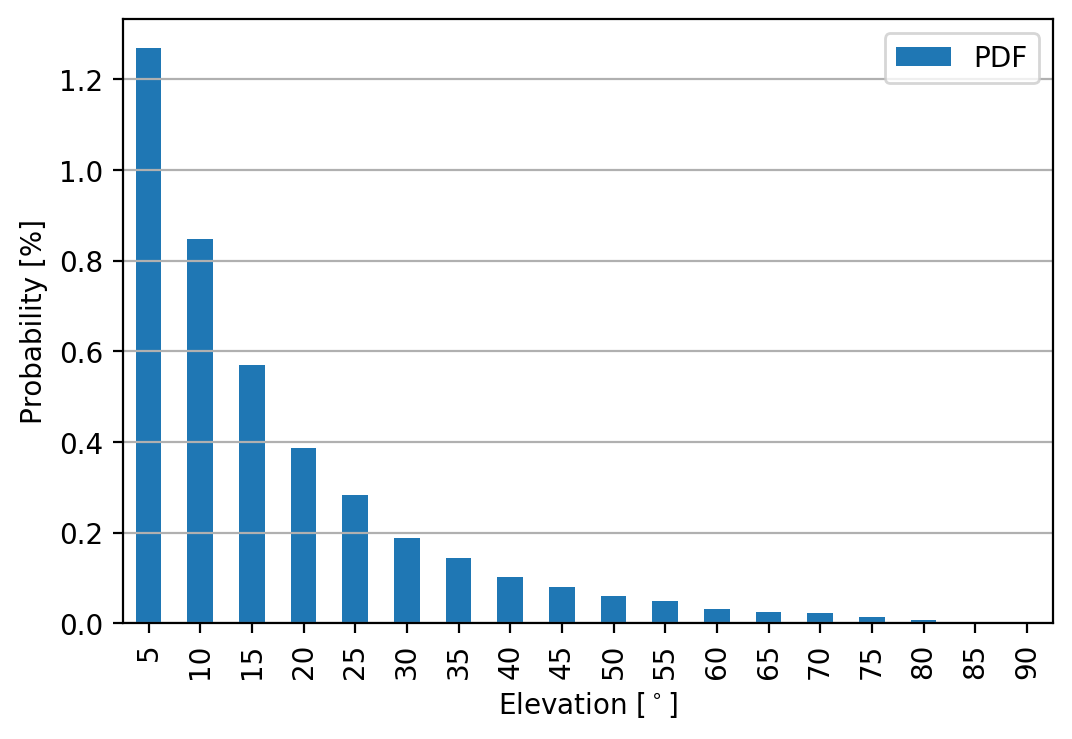

In [5]:
stp = 5
bins = np.arange(5,91,stp)

stat = pd.DataFrame(index=bins)

for bin in bins:
    ind  = np.logical_and( bin <= df['EL'] , df['EL'] < bin+stp)

    el = df.loc[ind,'EL']

    stat.loc[bin,'PDF'] = np.size(el)/np.size(ind) * 100


fig, ax = plt.subplots(dpi=200)
ax = stat.plot(ax=ax, y='PDF', kind='bar')

ax.grid(b=True, which='major', axis='y')

ax.set_xlabel(r'Elevation [$^\circ$]')
ax.set_ylabel(r'Probability [%]')
plt.show()

